In [1]:
from common import *
from experiment import *
from data import RawData, PlottableData

In [2]:
TREATMENTS = [
    TCPTreatment(cca='cubic', pep=False),
    TCPTreatment(cca='cubic', pep=True),
    TCPTreatment(cca='bbr', pep=False),
    TCPTreatment(cca='bbr', pep=True),
    TCPTreatment(cca='bbrv2', pep=False),
    TCPTreatment(cca='bbrv2', pep=True),
]
TCP_CUBIC = TREATMENTS[0]
PEP_CUBIC = TREATMENTS[1]
TCP_BBR = TREATMENTS[2]
PEP_BBR = TREATMENTS[3]
TCP_BBRV2 = TREATMENTS[4]
PEP_BBRV2 = TREATMENTS[5]

In [3]:
NETWORKS = [
    NetworkSetting(),
]
DEFAULT_NETWORK = NETWORKS[0]

# Data size vs. throughput for fixed data sizes bar graph, with error bars

In [17]:
def plot_data_size_vs_metric_bar(data, delta, title, ylabel):
    plt.figure(figsize=(6, 4))
    
    labels = data.treatments
    assert len(data.network_settings) == 1
    network = data.network_settings[0]

    # Prepare data
    xs_raw = sorted(data.data[labels[0]][network].keys())  # Assumes all labels share the same x-axis keys
    xs = [x/1000 for x in xs_raw]  # Convert to KB
    width = 0.6 / len(labels)  # Width of each bar
    x_positions = np.arange(len(xs))  # X positions for groups of bars

    # Plot bars for each label
    for i, label in enumerate(labels):
        subdata = data.data[label][network]
        ys_raw = [subdata[x] for x in xs_raw]
        ys = [y.p(50) for y in ys_raw]
        yerr_lower = [y.p(50) - y.p(50-delta) for y in ys_raw]
        yerr_upper = [y.p(50+delta) - y.p(50) for y in ys_raw]
        positions = x_positions + i * width
        plt.bar(
            positions, ys, width=width, yerr=(yerr_lower, yerr_upper), 
            capsize=5, label=label, alpha=0.8
        )

    # Customize plot
    plt.xticks(x_positions + width * (len(labels) - 1) / 2, [f'{x:.1f}' for x in xs])  # Center tick labels
    plt.title(title)
    plt.xlabel('Download Data Size (KB)')
    plt.ylabel(ylabel)
    plt.grid(axis='y')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=len(labels))
    plt.tight_layout()
    plt.show()

In [18]:
execute = False
num_trials = 50
treatments = [TCP_CUBIC, PEP_CUBIC, TCP_BBR, PEP_BBR]
network_settings = [DEFAULT_NETWORK]
data_sizes = [
    100,
    1000,
    10000,
    100000,
    1000000,
]
exp = Experiment(num_trials, treatments, network_settings, data_sizes)
raw_data = RawData(exp, execute=execute)

MISSING: sudo -E python3 emulation/main.py -t 49 --label tcp_cubic tcp -cca cubic -n 100
MISSING: sudo -E python3 emulation/main.py -t 49 --label tcp_cubic tcp -cca cubic -n 1000
MISSING: sudo -E python3 emulation/main.py -t 49 --label tcp_cubic tcp -cca cubic -n 10000
MISSING: sudo -E python3 emulation/main.py -t 49 --label tcp_cubic tcp -cca cubic -n 100000
MISSING: sudo -E python3 emulation/main.py -t 49 --label tcp_cubic tcp -cca cubic -n 1000000
MISSING: sudo -E python3 emulation/main.py -t 49 --label pep_cubic tcp --pep -cca cubic -n 100
MISSING: sudo -E python3 emulation/main.py -t 49 --label pep_cubic tcp --pep -cca cubic -n 1000
MISSING: sudo -E python3 emulation/main.py -t 49 --label pep_cubic tcp --pep -cca cubic -n 10000
MISSING: sudo -E python3 emulation/main.py -t 49 --label pep_cubic tcp --pep -cca cubic -n 100000
MISSING: sudo -E python3 emulation/main.py -t 49 --label pep_cubic tcp --pep -cca cubic -n 1000000
MISSING: sudo -E python3 emulation/main.py -t 49 --label tcp

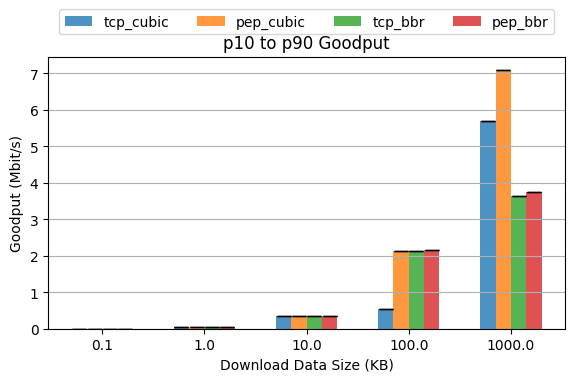

In [20]:
delta = 40
title = f'p{50-delta} to p{50+delta} Goodput'
metric = 'throughput_mbps'
ylabel = 'Goodput (Mbit/s)'
plottable_data = PlottableData(raw_data, metric=metric)
plot_data_size_vs_metric_bar(plottable_data, delta=delta, title=title, ylabel=ylabel)

# Data size vs. thoughput line graph, with error bars

In [12]:
def plot_data_size_vs_metric_line(data, delta, title, ylabel):
    plt.figure(figsize=(6, 4))
    
    labels = data.treatments
    assert len(data.network_settings) == 1
    network = data.network_settings[0]

    for label in labels:
        subdata = data.data[label][network]
        xs_raw = sorted(subdata.keys())
        ys_raw = [subdata[x] for x in xs_raw]

        xs = [x/1000 for x in xs_raw]
        ys = [y.p(50) for y in ys_raw]
        yerr_lower = [y.p(50) - y.p(50-delta) for y in ys_raw]
        yerr_upper = [y.p(50+delta) - y.p(50) for y in ys_raw]
        plt.errorbar(xs, ys, yerr=(yerr_lower, yerr_upper), marker='.', capsize=5, label=label)

    plt.title(title)
    plt.xlabel('Download Data Size (KB)')
    plt.ylabel(ylabel)
    plt.grid()
    plt.xlim(0)
    plt.ylim(0)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)
    plt.show()

In [13]:
execute = True
num_trials = 50
treatments = [TCP_CUBIC, PEP_CUBIC, TCP_BBR, PEP_BBR]
network_settings = [DEFAULT_NETWORK]
data_sizes = [
    100,
    1000,
    10000,
    100000,
    1000000,
    10000000,
]
exp = Experiment(1, treatments, network_settings, data_sizes)
raw_data = RawData(exp, execute=True)

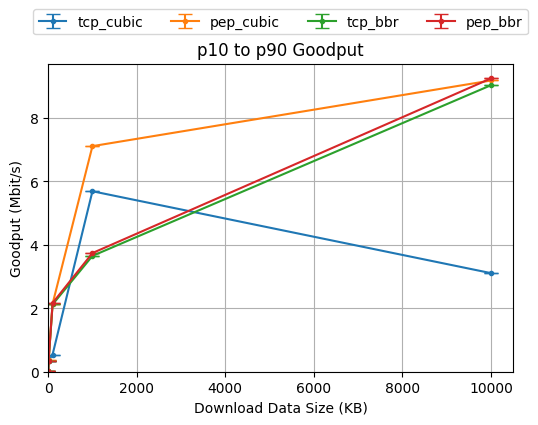

In [14]:
delta = 40
title = f'p{50-delta} to p{50+delta} Goodput'
metric = 'throughput_mbps'
ylabel = 'Goodput (Mbit/s)'
plottable_data = PlottableData(raw_data, metric=metric)
plot_data_size_vs_metric_line(plottable_data, delta=delta, title=title, ylabel=ylabel)

# Latency CDF for fixed data size

In [29]:
def plot_metric_cdf(data, title, xlabel):
    plt.figure(figsize=(6, 4))
    
    labels = data.treatments
    assert len(data.network_settings) == 1
    network = data.network_settings[0]
    assert len(data.data_sizes) == 1
    data_size = data.data_sizes[0]

    for label in labels:
        subdata = data.data[label][network][data_size]
        xs = subdata.sorted_data
        cdf = [i / len(xs) for i in range(1, len(xs) + 1)]
        plt.plot(xs, cdf, label=label)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('CDF')
    plt.grid()
    plt.xlim(0)
    plt.ylim(0, 1.05)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(labels))
    plt.tight_layout()
    plt.show()

In [28]:
execute = True
num_trials = 100
treatments = [TCP_CUBIC, PEP_CUBIC, TCP_BBR, PEP_BBR]
network_settings = [DEFAULT_NETWORK]
data_size = 1000
exp = Experiment(40, treatments, network_settings, [data_size])
raw_data = RawData(exp, execute=execute)

4
sudo -E python3 emulation/main.py -t 9 --label tcp_cubic tcp -cca cubic -n 1000 5.371671676635742
sudo -E python3 emulation/main.py -t 10 --label pep_cubic tcp --pep -cca cubic -n 1000 4.375939130783081
sudo -E python3 emulation/main.py -t 10 --label pep_cubic tcp --pep -cca cubic -n 1000 4.234137296676636
sudo -E python3 emulation/main.py -t 10 --label pep_cubic tcp --pep -cca cubic -n 1000 4.153936147689819
sudo -E python3 emulation/main.py -t 9 --label pep_cubic tcp --pep -cca cubic -n 1000 3.832570791244507
sudo -E python3 emulation/main.py -t 10 --label tcp_bbr tcp -cca bbr -n 1000 4.511684417724609
sudo -E python3 emulation/main.py -t 10 --label tcp_bbr tcp -cca bbr -n 1000 4.211658000946045
sudo -E python3 emulation/main.py -t 10 --label tcp_bbr tcp -cca bbr -n 1000 4.179614782333374
sudo -E python3 emulation/main.py -t 9 --label tcp_bbr tcp -cca bbr -n 1000 4.14276909828186
sudo -E python3 emulation/main.py -t 10 --label pep_bbr tcp --pep -cca bbr -n 1000 4.165461301803589
su

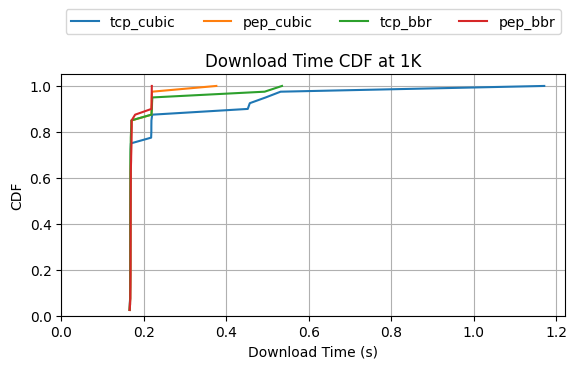

In [30]:
title = f'Download Time CDF at {data_size_str(data_size)}'
metric = 'time_s'
xlabel = 'Download Time (s)'
plottable_data = PlottableData(raw_data, metric=metric)
plot_metric_cdf(plottable_data, title=title, xlabel=xlabel)